# Data Loading

In [9]:
import numpy as np
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchvision.utils import make_grid , save_image
import scipy.io
import matplotlib.pyplot as plt

## Binary Alpha Digits

In [13]:
import os
data_folder = './data'
for dirname, _, filenames in os.walk(data_folder):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./data/binaryalphadigs.mat


In [17]:
data_binaryalphadigits = os.path.join(data_folder, 'binaryalphadigs.mat')

In [77]:
data = scipy.io.loadmat(data_binaryalphadigits)
images = data['dat']
flattened_images = [img.flatten() for img in images[0]]

# convert to tensor
image_tensor = torch.tensor(np.array(flattened_images), dtype=torch.float32)

In [74]:
import random

def display_image(images, num_images=5):
    # Randomly select indices for the images
    random_indices = random.sample(range(len(images)), num_images)
    
    # Set up a grid for the images
    fig, axes = plt.subplots(1, num_images, figsize=(5, 5))
    
    # Loop through the random indices and display each image
    for i, idx in enumerate(random_indices):
        image = images[idx].reshape(20, 16)  # Reshape the image to 20x16 if needed
        axes[i].imshow(image, cmap='gray')
        axes[i].set_title(f'Image {idx}')
        axes[i].axis('off')  # Hide the axes
    
    plt.tight_layout()
    plt.show()

In [52]:
image_tensor.shape

torch.Size([39, 320])

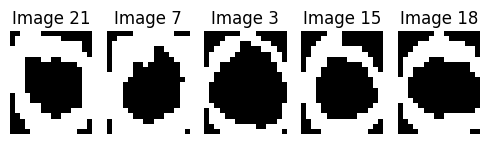

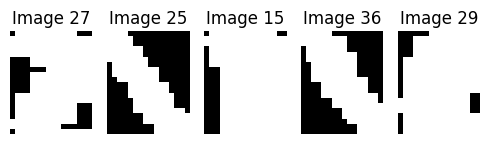

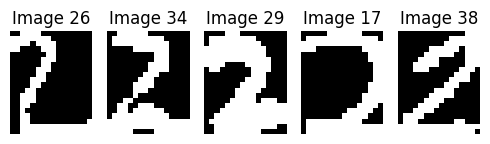

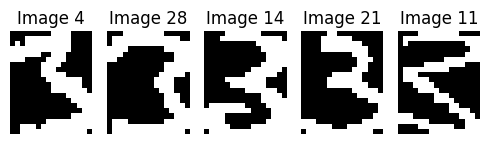

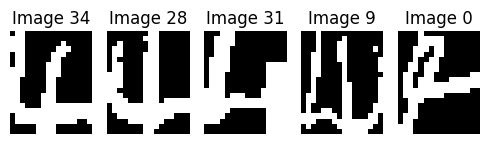

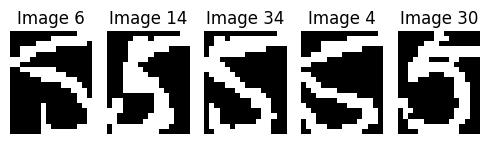

In [76]:
display_image(images[0])
display_image(images[1])
display_image(images[2])
display_image(images[3])
display_image(images[4])
display_image(images[5])

# Model

## Definition

In [112]:
class RBM(nn.Module):

    def __init__(self, p: int, q:int):
        super(RBM, self).__init__()
        self.p = p
        self.q = q

        # Notes:
        # nn.Parameters automatically adds the variable to the list of the model's parameters
        # nn.Parameter tells Pytorch to include this tensor in the computation graph and compute gradients for it during backprop
        # nn.Parameter allow params to move to the right devide when appluing .to(device)

        # Parameters
        self.W = nn.Parameter(torch.randn(q, p)*1e-2)

        # Bias - initialised at 0
        self.a = nn.Parameter(torch.zeros(p))
        self.b = nn.Parameter(torch.zeros(q))
        
    def entree_sortie(self, v):
        # F.linear performs: v.W + b
        sigm = torch.sigmoid(F.linear(v, self.W, self.b))
        return sigm

    def sortie_entree(self, h):
        # F.linear performs: h.W(transpose) + a
        sigm = torch.sigmoid(F.linear(h, self.W.t(), self.a))
        return sigm

    def forward(self, v):
        raise NotImplementedError("Use the train method for training the RBM.")

    def train(self, V, nb_epoch, batch_size, eps=0.001):
        """
        Train the RBM using Contrastive Divergence

        Args:
        - V: input data
        - nb_epoch: Number of epoch
        - batch_size: Batch size
        - eps: Learning rate
        """
        n = V.size(0)
        p, q = self.p, self.q

        for epoch in range(nb_epoch):
            # Shuffle dataset
            V = V[torch.randperm(n)]
            
            # Iterate with batch_size step
            for j in range(0, n, batch_size):
                V_batch = V[j:min(j + batch_size, n)]
                batch_size_actual = V_batch.size(0)

                v_0 = V_batch
                p_h_v_0 = self.entree_sortie(v_0)
                # Sample
                h_0 = (torch.rand(batch_size_actual, q) < p_h_v_0).float()
                
                p_v_h_0 = self.sortie_entree(h_0)
                v_1 = (torch.rand(batch_size_actual, p) < p_v_h_0).float()
                
                p_h_v_1 = self.entree_sortie(v_1)

                # grad
                grad_a = torch.sum(v_0 - v_1, dim=0)
                grad_b = torch.sum(p_h_v_0 - p_h_v_1, dim=0)
                grad_W = torch.matmul(v_0.t(), p_h_v_0) - torch.matmul(v_1.t(), p_h_v_1)

                # Update params - Normalise to batch size
                # Note: We bypass the pytorch computation graph with .data to avoid accumulating gradients
                self.W.data += eps * grad_W.t() / batch_size_actual
                self.b.data += eps * grad_b / batch_size_actual
                self.a.data += eps * grad_a / batch_size_actual

            H = self.entree_sortie(V)
            V_rec = self.sortie_entree(H)
            quad_error = torch.sum((V - V_rec)**2) / (n*p)
            print(f"Epoch {epoch+1}/{nb_epoch}, Reconstruction Error (EQ): {quad_error.item():.6f}")


## Training

In [118]:
rbm = RBM(p=image_tensor.size(1), q=64)

In [119]:
def train_rbm_on_dataset(rbm, data_folder, dataset='binaryalphadigs.mat', nb_epoch=10000, batch_size=64, eps=0.001, p=256, q=64):
    """
    Function to train the RBM model on the given dataset of binary images.

    Args:
    - data_folder: Path to the folder containing the 'binaryalphadigs.mat' file.
    - nb_epoch: Number of training epochs.
    - batch_size: Batch size for training.
    - eps: Learning rate for gradient update.
    - p: Number of visible units.
    - q: Number of hidden units.
    """

    # Load the dataset
    data_binaryalphadigits = os.path.join(data_folder, dataset)
    data = scipy.io.loadmat(data_binaryalphadigits)
    images = data['dat']
    flattened_images = [img.flatten() for img in images[0]]

    # Convert to tensor
    image_tensor = torch.tensor(np.array(flattened_images), dtype=torch.float32)

    # Normalize the data (if necessary)
    # Assuming the data is binary, no need to scale between 0 and 1 but if it isn't, you can scale it:
    # image_tensor = image_tensor / 255.0  # If data isn't binary, you can normalize

    # Initialize RBM model
    

    # Train the RBM
    rbm.train(image_tensor, nb_epoch=nb_epoch, batch_size=batch_size, eps=eps)

    print("Training complete.")

In [120]:
train_rbm_on_dataset(rbm, data_folder=data_folder)

Epoch 1/10000, Reconstruction Error (EQ): 0.249045
Epoch 2/10000, Reconstruction Error (EQ): 0.248187
Epoch 3/10000, Reconstruction Error (EQ): 0.247302
Epoch 4/10000, Reconstruction Error (EQ): 0.246428
Epoch 5/10000, Reconstruction Error (EQ): 0.245544
Epoch 6/10000, Reconstruction Error (EQ): 0.244660
Epoch 7/10000, Reconstruction Error (EQ): 0.243782
Epoch 8/10000, Reconstruction Error (EQ): 0.242877
Epoch 9/10000, Reconstruction Error (EQ): 0.241946
Epoch 10/10000, Reconstruction Error (EQ): 0.240993
Epoch 11/10000, Reconstruction Error (EQ): 0.240062
Epoch 12/10000, Reconstruction Error (EQ): 0.239108
Epoch 13/10000, Reconstruction Error (EQ): 0.238163
Epoch 14/10000, Reconstruction Error (EQ): 0.237209
Epoch 15/10000, Reconstruction Error (EQ): 0.236242
Epoch 16/10000, Reconstruction Error (EQ): 0.235244
Epoch 17/10000, Reconstruction Error (EQ): 0.234254
Epoch 18/10000, Reconstruction Error (EQ): 0.233269
Epoch 19/10000, Reconstruction Error (EQ): 0.232267
Epoch 20/10000, Recon

## Test

In [124]:
import matplotlib.pyplot as plt

def generer_image_RBM(rbm, num_iterations, num_images):
    """
    Generate samples from an RBM using Gibbs sampling.

    Args:
        rbm (RBM): The RBM object.
        num_iterations (int): Number of Gibbs sampling steps to use.
        num_images (int): Number of images to generate.

    Returns:
        torch.Tensor: A tensor of generated images.
    """
    # Initialize random visible states
    generated_images = torch.bernoulli(torch.rand(num_images, rbm.p))  # Random binary states

    # Perform Gibbs sampling
    for _ in range(num_iterations):
        # Sample hidden states given visible states
        p_h_given_v = rbm.entree_sortie(generated_images)
        h = (torch.rand_like(p_h_given_v) < p_h_given_v).float()

        # Sample visible states given hidden states
        p_v_given_h = rbm.sortie_entree(h)
        generated_images = (torch.rand_like(p_v_given_h) < p_v_given_h).float()

    # Plot the generated images
    fig, axes = plt.subplots(1, num_images, figsize=(num_images * 2, 2))
    for i, ax in enumerate(axes):
        ax.imshow(generated_images[i].view(int(rbm.p**0.5), int(rbm.p**0.5)), cmap="gray")
        ax.axis("off")
    plt.show()

    return generated_images


In [125]:
# Assume rbm is a trained RBM object
generated_images = generer_image_RBM(rbm, num_iterations=1000, num_images=5)